# Step 1

## Get links to scripts
Crawl Internet Movie Script Database (IMDSDb) for a link to each of their scripts and also find the script's genres. Each script can have more than one genre.

In [1]:
from bs4 import BeautifulSoup
import urllib.request

def fetch(url):
    request = urllib.request.Request(url)
    try:
        read_request = urllib.request.urlopen(request).read()#.decode('utf-8')
        return read_request
    except urllib.error.HTTPError:
        return False
    
def movie_title_from_hyperlink(hyperlink):
    return hyperlink["href"][len(script_link_first_part):-len(script_link_last_part)].replace(":", "")

script_folder_url = 'http://www.imsdb.com/scripts/'
genre_folder_url = 'http://www.imsdb.com/genre/'

script_link_first_part = "/Movie Scripts/"
script_link_last_part = " Script.html"

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Comedy",
    "Drama",
    "Family",
    "Fantasy",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    'Sci-Fi',
    'Thriller',
    "Western"
]

# Number of samples from each genre
samples_from_genres = []

# "Recent comments" is a side-bar linking to random scripts. Needs to be filtered out
nr_of_recent_comments = 5

# A dictionary with movie title as key. Each movie in the dictionary
# links to a list with all of its genres
movie_dict = dict([])

for i, genre in enumerate(genres):
    
    # Crawl IMSDb for genre
    genre_url = genre_folder_url + genre
    request_text = fetch(genre_url)
    soup = BeautifulSoup(request_text, "html5lib")
    all_hyperlinks = soup.find_all("a", href=True)
    
    found_scripts = 0
    # Get all movies from genre
    for hyperlink in all_hyperlinks:
        if script_link_first_part in hyperlink["href"]: # Check if it is a link to a movie script
            
            found_scripts += 1
            if found_scripts > nr_of_recent_comments:
                
                title = movie_title_from_hyperlink(hyperlink)

                if title not in movie_dict:
                    movie_dict[title] = [0]*len(genres)
                movie_dict[title][i] = 1
    samples_from_genres.append(found_scripts - 5)
    print("nr of movies from", genre, "is", found_scripts - 5)
    
print("Number of links: %d" % ( len(movie_dict) ))
#print(movie_dict)

nr of movies from Action is 326
nr of movies from Adventure is 191
nr of movies from Animation is 40
nr of movies from Comedy is 383
nr of movies from Drama is 628
nr of movies from Family is 51
nr of movies from Fantasy is 128
nr of movies from Horror is 152
nr of movies from Musical is 26
nr of movies from Mystery is 120
nr of movies from Romance is 206
nr of movies from Sci-Fi is 171
nr of movies from Thriller is 400
nr of movies from Western is 17
Number of links: 1167


## Iterate over all links and get scripts
Now we iterate over all previously found links to download the scripts.

In [ ]:
def get_movie_script(movie_title):
    
    script_url = script_folder_url + movie_title.strip(":").replace(" ","-") + ".html"
    request_text = fetch(script_url)
    
    if not request_text: # Check if we got error when attempting to fetch script url
        return ""
    
    soup = BeautifulSoup(request_text, "html5lib")
    
    script = soup.findAll("pre") #
    script_text = ""
    
    if script:
        script_text = script[-1].get_text() # Get all text within most inner "<pre>...</pre>"
    
    return script_text


titles = []
scripts = []
labels = []

for i, movie_title in enumerate(movie_dict.keys()):
    
    script = get_movie_script(movie_title)
    if script != "": # Check if the script was found
        titles.append(movie_title)
        scripts.append(script.replace("\n"," ").replace("\\",""))
        labels.append(movie_dict[movie_title])
    
    if i % 5 == 0: # Just to see progress
        print(i)

scripts_and_labels = {"titles": np.array(titles), "scripts":np.array(scripts), "labels": np.array(labels)}

# Save/Load scripts to file to save time re-crawling

### Save scripts

In [33]:
import pickle
pickle.dump(scripts_and_labels , open( "pickled_scripts_and_labels.p", "wb" ))

### Load scripts

In [2]:
import pickle
scripts_and_labels = pickle.load(open( "pickled_scripts_and_labels.p", "rb" ))

# Step 2

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words("english"))

## Preprocess all scripts

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import time
import os

os.environ["JAVAHOME"] = "C:\\Programming_Languages\\Java\\jre\\bin\\"
nltk.internals.config_java("C:/Programming_Languages/Java/bin/java.exe")
st = StanfordNERTagger('stanford-ner-2017-06-09/classifiers/english.all.3class.distsim.crf.ser.gz',
                       'stanford-ner-2017-06-09/stanford-ner.jar',
                       encoding='utf-8')

lmtzr = WordNetLemmatizer()

def preprocess(doc, stops):
    doc = doc.split()

    script_extra_stop_words = {"contd", "ext", "int", "wwwimsdbcom", "script", "continued", "wwwscreentalkorg", "pdf", "imsdb",
                              "int","cont","continued","fran","lynn","marlene","nick","beth","catherine","sid","audrey","willie","indiana","indy","marcus","jack","rachel","jackie","luke","jack","david","michael","anne","digger","sean","rothsam","lynn","william","bob","phil","charlotte","betty","larry","andrew","matt","joe","steve","danny","benedict","evelyn","ellie","trevor","hammond","alan","doug","browning","kate","harvey","charlie","barnes"}
    stops = stops.union(script_extra_stop_words)

    
    classified_text = st.tag(doc)
    
    t1 = time.time()
    new_doc = []
    
    for i, word in enumerate(doc):
        new_word = lmtzr.lemmatize(re.sub(r'\W+', '', word)).replace("/","")
    #    #print(new_word)
    #    #print(st.tag([new_word]))

            
        
        if new_word != "" and i < len(classified_text) and classified_text[i][0] == word.replace("/","") and classified_text[i][1] != "PERSON":
            new_doc.append(new_word.lower())
            
    print(time.time()-t1, "seconds")
    #return ' '.join(new_doc)
    return ' '.join(doc)

preprocessed_scripts = []
for script in scripts_and_labels["scripts"]:
    preprocessed_scripts.append(preprocess(script, stops))
    
preprocessed_scripts = np.array(preprocessed_scripts)
print("Preprocessed all scripts")


In [8]:
import pickle
pickle.dump(preprocessed_scripts , open( "pickled_preprocessed_scripts.p", "wb" ))

In [3]:
import pickle
preprocessed_scripts = pickle.load(open( "pickled_preprocessed_scripts.p", "rb" ))

## Analyze token statistics

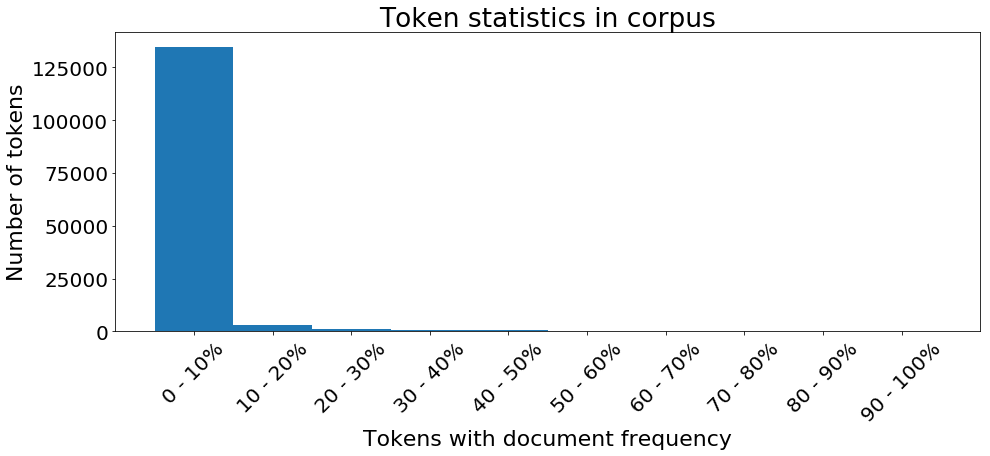

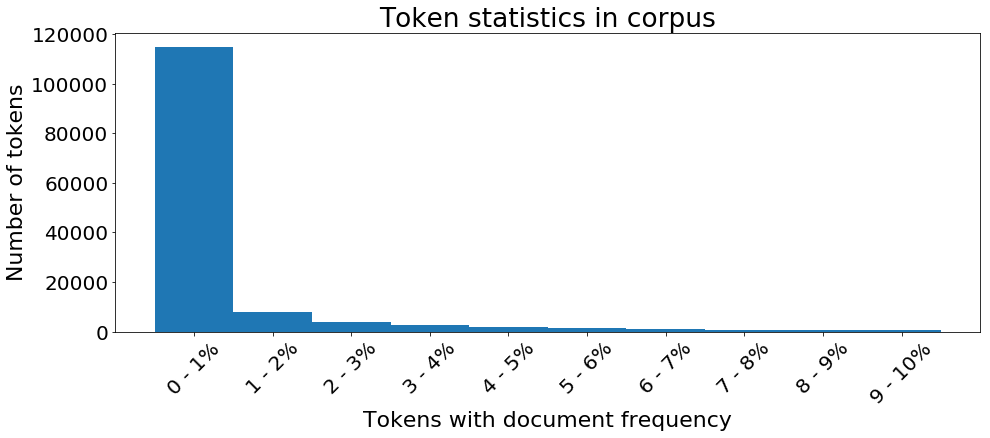

In [357]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=20)

plt.rc('ytick', labelsize=20)

'''
word_in_ranges = []

for word_range in range(1, 11):
    word_range /= 10
    transvector = TfidfVectorizer(stop_words = "english", min_df = word_range - 0.1, max_df = word_range)
    scripts_tfidf = transvector.fit_transform(preprocessed_scripts)
    word_in_ranges.append(len(transvector.idf_))
'''
x = np.arange(10)

fig, ax = plt.subplots()
plt.title('Token statistics in corpus')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, word_in_ranges, width=1)
plt.xticks(x, [str(w-10) + " - " + str(w) + "%" for w in range(10,110,10)], rotation=45)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of tokens')
ax.set_xlabel('Tokens with document frequency')
plt.show()
'''
zoomed_word_in_ranges = []

for word_range in range(1, 11):
    word_range /= 100
    transvector = TfidfVectorizer(stop_words = "english", min_df = word_range - 0.01, max_df = word_range)
    scripts_tfidf = transvector.fit_transform(preprocessed_scripts)
    zoomed_word_in_ranges.append(len(transvector.idf_))

x = np.arange(10)'''

fig, ax = plt.subplots()
plt.title('Token statistics in corpus')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, zoomed_word_in_ranges, width=1)
plt.xticks(x, [str(w-1) + " - " + str(w) + "%" for w in range(1,11,1)], rotation=45)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of tokens')
ax.set_xlabel('Tokens with document frequency')
plt.show()



## Compute tf-idf

In [305]:
transvector = TfidfVectorizer(stop_words = "english", min_df = 0.04, max_df = 0.5)

scripts_tfidf = transvector.fit_transform(preprocessed_scripts)

vocab = dict([[v,k] for k,v in transvector.vocabulary_.items()])

print(len(transvector.idf_))


(1119, 9895)
9895


# Split into training and test

In [306]:
import numpy as np
# Shuffle the scripts_tfidf and labels together
rng = np.random.seed(None)
p = np.random.permutation(scripts_tfidf.shape[0])
scripts_tfidf = scripts_tfidf[p]
labels = np.array(scripts_and_labels["labels"])[p]
movie_names = np.array(scripts_and_labels["titles"])[p]

print(len(scripts_and_labels["labels"]))
print(len(preprocessed_scripts))
cut_point = int(scripts_tfidf.shape[0]/2) # split 50-50 train test

x_train = scripts_tfidf[:cut_point]
y_train = labels[:cut_point]
titles_train = movie_names[:cut_point]
#y_train = np.array(scripts_and_labels["labels"][:cut_point])

x_test = scripts_tfidf[cut_point:]
y_test = labels[cut_point:]
titles_test = movie_names[cut_point:]
#y_test =  np.array(scripts_and_labels["labels"][cut_point:])

print("Successfully split data into training and test")


1119
1119
Successfully split data into training and test


# Training a classifier

In [402]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


#classifier = tree.DecisionTreeClassifier()
#classifier = tree.ExtraTreeClassifier() 
#classifier = ensemble.ExtraTreesClassifier(n_estimators=5) 
#classifier = ensemble.RandomForestClassifier(n_estimators=100)
classifier = KNeighborsClassifier(n_neighbors=3) #
#classifier = MLPClassifier(hidden_layer_sizes = (100,),solver='lbfgs', alpha=1e-4)#, random_state=42)
classifier.fit(x_train, y_train)
#print(classifier.n_layers_)

#preds = classifier.predict(x_test)

pred_distr = preds.sum(axis=0,  dtype='int')
y_train_distr = y_train.sum(axis=0,  dtype='int') 
y_test_distr = y_test.sum(axis=0,  dtype='int')


# Since some models sometimes fail to predict any genre, we use a
# secondary classifier to classify every movie without any predicted genres
#secondary_classifier = tree.DecisionTreeClassifier()
#secondary_classifier.fit(x_train, y_train)

for x in range(len(preds)):
    if sum(preds[x]) == 0:
        preds[x] = secondary_classifier.predict(x_test[x])[0]

accuracy = accuracy_score(y_test,preds)
print("my accuracy is:", accuracy)

recall = recall_score(y_test, preds, labels = range(1,14), average = 'micro')
print("my recall is:", recall)

precision = precision_score(y_test, preds, labels = range(1,14), average = 'micro')
print("my precision is:", precision)

flattened_accuracy = accuracy_score(y_test.flatten(),preds.flatten())
print("my flattened accuracy is:", flattened_accuracy)


my accuracy is: 0.1125
my recall is: 0.399835796388
my precision is: 0.500513874615
my flattened accuracy is: 0.827423469388


## Print correctly predicted movies

In [363]:
def print_prediction_genres(pred_array):
    """Prints the predicted genres from a prediction array."""
    print([genre for index, genre in enumerate(genres) if list(pred_array)[index] == 1])

def pred_equal_ytest(x):
    """x is the prediction's index"""
    return sum([1 for y in range(len(preds[x])) if int(preds[x,y]) == int(y_test[x,y])]) == len(genres)

number_of_correct_scripts = 0
for x in range(len(preds)):
    
    if sum(preds[x]) == 0:
        print("Found script without any predicted genres:", preds[x])
        
    if pred_equal_ytest(x):
    #if not pred_equal_ytest(x):
        print(titles_test[x], end=" - ")
        print_prediction_genres(preds[x])
        number_of_correct_scripts += 1
print(number_of_correct_scripts)

Obsessed - ['Drama', 'Thriller']
Silence of the Lambs - ['Drama', 'Horror', 'Thriller']
Body Heat - ['Thriller']
Office Space - ['Comedy']
Collateral Damage - ['Action', 'Thriller']
Horse Whisperer, The - ['Drama', 'Romance']
Queen, The - ['Drama']
Candle to Water - ['Drama']
Master, The - ['Drama']
Pianist, The - ['Drama']
Invictus - ['Drama']
I'll Do Anything - ['Comedy', 'Drama']
Papadopoulos & Sons - ['Comedy', 'Drama']
Terminator 2 Judgement Day - ['Action', 'Drama', 'Sci-Fi', 'Thriller']
Terminator Salvation - ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Judge Dredd - ['Action', 'Sci-Fi']
Insidious - ['Horror', 'Thriller']
Barry Lyndon - ['Drama', 'Romance']
Boogie Nights - ['Drama']
Alien Resurrection - ['Action', 'Horror', 'Sci-Fi', 'Thriller']
Man on the Moon - ['Comedy', 'Drama']
Verdict, The - ['Drama']
Life As A House - ['Comedy', 'Drama']
Life of David Gale, The - ['Drama', 'Thriller']
RKO 281 - ['Drama']
Lord of the Rings Return of the King - ['Action', 'Adventure', 'Fan

## Genre distributions

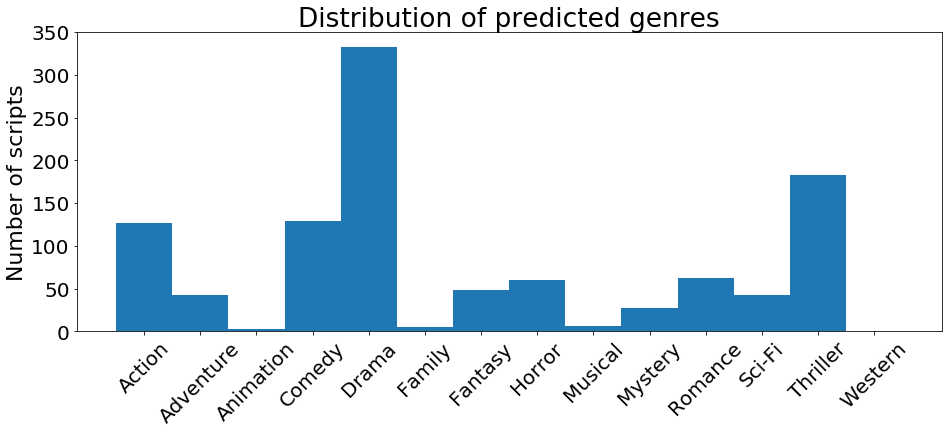

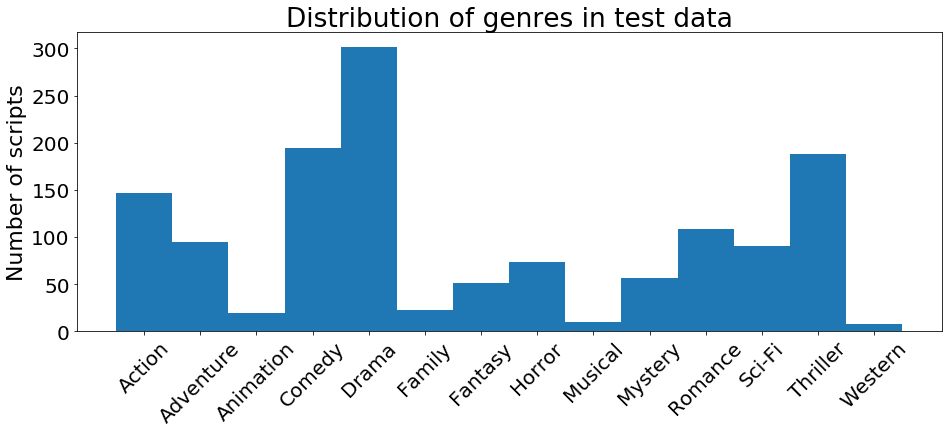

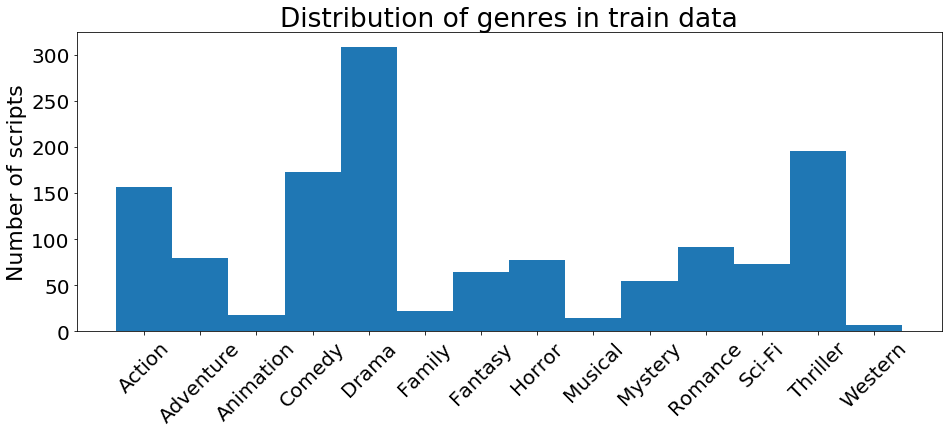

In [364]:
x = np.arange(len(genres))

fig, ax = plt.subplots()
plt.title('Distribution of predicted genres')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, pred_distr, width=1)
plt.xticks(x, genres, rotation=45)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
plt.show()

fig, ax = plt.subplots()
plt.title('Distribution of genres in test data')
plt.bar(x, y_test_distr, width=1)
plt.xticks(x, genres, rotation=45)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
plt.show()

fig, ax = plt.subplots()
plt.title('Distribution of genres in train data')
plt.bar(x, y_train_distr, width=1)
plt.xticks(x, genres, rotation=45)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
plt.show()

## Accuracy per amount of script genres
As a script can either have one, two, or five genres, we study how the accuracy depends on the number of genres.

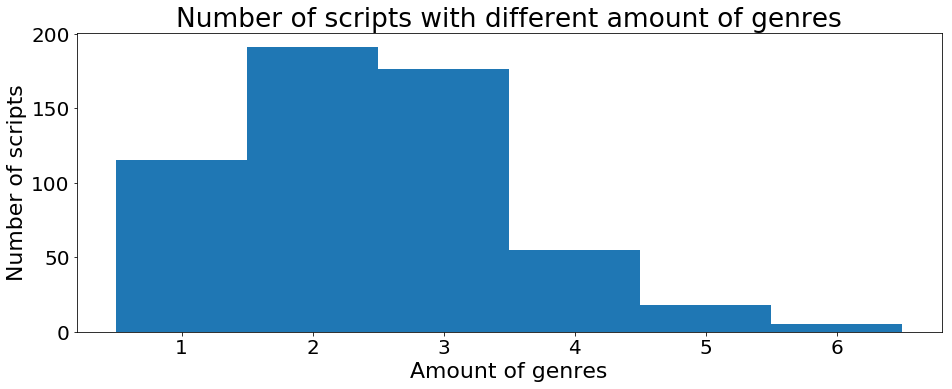

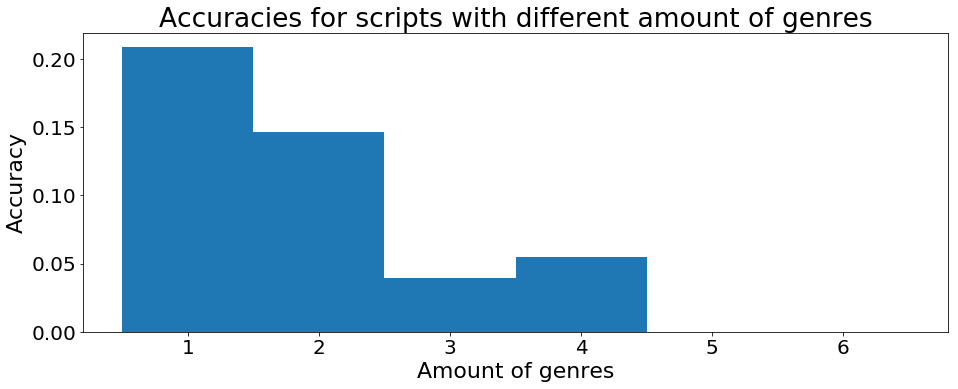

In [366]:
## Proportion of correct predictions

max_nr_of_genres = len(genres)
correct_preds_per_nr_of_genres = [0] * max_nr_of_genres
scripts_per_nr_of_genres = [0] * max_nr_of_genres

for x in range(len(preds)):
    
    if pred_equal_ytest(x):
        correct_preds_per_nr_of_genres[sum(preds[x])] += 1
    scripts_per_nr_of_genres[sum(y_test[x])] += 1

accuracy_per_nr_of_genres = [x/y for x,y in zip(correct_preds_per_nr_of_genres, scripts_per_nr_of_genres) if y != 0]



x = np.arange(len(accuracy_per_nr_of_genres))

# Plot number of scripts per amount of genres
fig, ax = plt.subplots()
plt.title('Number of scripts with different amount of genres')
plt.bar(x, scripts_per_nr_of_genres[1: len(accuracy_per_nr_of_genres)+1], width=1)
plt.xticks(x, range(1, len(accuracy_per_nr_of_genres)+1))
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
ax.set_xlabel('Amount of genres')
plt.show()

# Plot accuracy per amount of genres
fig, ax = plt.subplots()
plt.title('Accuracies for scripts with different amount of genres')
plt.bar(x, accuracy_per_nr_of_genres, width=1)
plt.xticks(x, range(1, len(accuracy_per_nr_of_genres)+1))
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Amount of genres')
plt.show()

## Using one multinomial classifier for each genre
When using one separate multinomial classifier for each genre, we end up with solely drama predictions, resulting in 12.6% accuracy. This is the highest achieved accuracy; however, it is not satisfying. Furthermore, this proves that accuracy might not be the best measure in this case. After all, I would rather have `[Action, Thriller, Adventure]` than `[Drama]` when the true answer is `[Action, Thriller, Adventure, Drama]`. When using simple accuracy as a measure of success, the model's potential complexity is somewhat hidden.

In [152]:
final_preds = []

for genre_index in range(len(genres)):
    genre_y_train = np.array([x[genre_index] for x in y_train])#.reshape(-1, 1)
    genre_y_test = np.array([x[genre_index] for x in y_test])#.reshape(-1, 1)

    classifier = MultinomialNB()
    #classifier = svm.SVC()
    #classifier = linear_model.SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None) #82% tot acc
    #classifier = KNeighborsClassifier(n_neighbors=3)
    #classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 2), random_state=42)
    #classifier = tree.DecisionTreeClassifier(min_samples_leaf = 3)
    #classifier = AdaBoostClassifier(n_estimators=10)
                        
    classifier.fit(x_train, genre_y_train)
    pred = classifier.predict(x_test)                        
    accuracy = accuracy_score(genre_y_test,pred)
    

    print("Genre:", genres[genre_index])
    print("Accuracy:", accuracy)
    print("Samples in genre:", samples_from_genres[genre_index])   
    print("")
    
    if genre_index == 0:
        final_preds = [[pred[x]] for x in range(len(genre_y_test))]
    else:
        for i in range(len(pred)):
            final_preds[i].append(pred[i])
            

correct = 0

for x in range(len(final_preds)):
    if sum([1 for y in range(len(final_preds[x])) if int(final_preds[x][y]) == int(y_test[x][y])]) == len(genres):
        correct += 1
        print(titles_test[x], end=" - ")
        print_prediction_genres(final_preds[x])
        
print("Accuracy:", correct/len(final_preds))

Genre: Action
Accuracy: 0.717857142857
Samples in genre: 326

Genre: Adventure
Accuracy: 0.833928571429
Samples in genre: 191

Genre: Animation
Accuracy: 0.960714285714
Samples in genre: 40

Genre: Comedy
Accuracy: 0.678571428571
Samples in genre: 383

Genre: Drama
Accuracy: 0.605357142857
Samples in genre: 628

Genre: Family
Accuracy: 0.95
Samples in genre: 51

Genre: Fantasy
Accuracy: 0.9
Samples in genre: 128

Genre: Horror
Accuracy: 0.839285714286
Samples in genre: 152

Genre: Musical
Accuracy: 0.973214285714
Samples in genre: 26

Genre: Mystery
Accuracy: 0.907142857143
Samples in genre: 120

Genre: Romance
Accuracy: 0.823214285714
Samples in genre: 206

Genre: Sci-Fi
Accuracy: 0.844642857143
Samples in genre: 171

Genre: Thriller
Accuracy: 0.653571428571
Samples in genre: 400

Genre: Western
Accuracy: 0.991071428571
Samples in genre: 17

An Education - ['Drama']
Dead Poets Society - ['Drama']
Woodsman, The - ['Drama']
Confessions of a Dangerous Mind - ['Drama']
Believer, The - ['D